## 第4天：逻辑回归手动实现
### ✅ 用 make_classification(n_features=2, n_redundant=0) 生成 2D 二分类数据
### ✅ 自己实现：
### Sigmoid 函数
### 交叉熵损失函数
### 梯度下降更新规则
### ✅ 迭代训练，记录损失变化
### ✅ 与 sklearn LogisticRegression 结果对比（准确率、决策边界）
### 💡 提示：初始化权重为 0，学习率设为 0.01，迭代 1000 老啊

In [11]:
# 第4天：逻辑回归手动实现（从零开始）
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. 生成二分类数据集（2个特征，便于可视化）
X, y = make_classification(
    n_samples=200,   # 200 个样本
    n_features=2,   # 2 个特征
    n_redundant=0,  # 没有冗余特征，冗余特征数为0
    n_informative=2,    # 2 个特征都是对分类有帮助的
    n_clusters_per_class=1, # 每个类别只包含 1 个簇（cluster）。也就是说，每一类的数据点大致聚集在一个区域，不会分散成多个子群
    random_state=42
)

print(f"数据形状: X={X.shape}, y={y.shape}")
print(f"类别分布: {np.bincount(y)}")

数据形状: X=(200, 2), y=(200,)
类别分布: [100 100]


In [14]:
# 2. 标准化特征（加速梯度下降收敛）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.69234315, -0.95937087],
       [ 0.82069175,  1.72635604],
       [ 1.53191344,  1.38591532],
       [ 1.50015542, -1.3659295 ],
       [ 0.56539135, -0.5072529 ],
       [-0.17089353, -0.47640495],
       [ 0.0164698 , -0.1830792 ],
       [-0.09326952, -1.41313063],
       [-0.95609575, -0.9061428 ],
       [-0.25695172,  0.19649946],
       [-1.41773417,  1.87090978],
       [ 0.2497229 ,  2.44247312],
       [ 1.47451964,  0.79583752],
       [-2.24906671, -0.366065  ],
       [ 1.21160414, -0.47441151],
       [ 0.23573561, -0.20536761],
       [ 0.24694403, -0.92489565],
       [-0.46352297,  2.43232779],
       [ 0.63340119,  0.10129453],
       [ 1.04270278, -0.3952922 ],
       [ 1.19768186,  0.72095232],
       [-1.75745228, -1.75730071],
       [ 0.51743223, -0.49662125],
       [-0.02215076, -0.41177938],
       [-1.23018465, -1.03728998],
       [-0.53973202, -1.15867675],
       [ 1.36723612,  1.31369318],
       [ 1.95900777,  0.98968713],
       [-1.26522395,

In [6]:
# 3. 手动实现逻辑回归类
class ManualLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000, tol=1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol

    def _sigmoid(self, z):
        """Sigmoid 激活函数，将线性输出映射到 (0, 1)"""
        # 防止溢出：clip z 到合理范围
        z = np.clip(z,  # z : 输入的数组
                    -500,   # 限定的最小值 也可以是数组 如果为数组时 shape必须和z一样
                    500)     # 限定的最大值 也可以是数组 shape和a一样
        return 1 / (1 + np.exp(-z))

    def _add_bias(self, X):
        """添加偏置列（全1）"""
        return np.c_[np.ones(X.shape[0]), X]        # 将一维或二维数组按列拼接，自动处理形状适配（如将 1D 转为列向量）

    def fit(self, X, y):
        """训练模型：使用梯度下降优化参数"""
        X_b = self._add_bias(X)
        m, n = X_b.shape

        # 初始化参数 theta（包括截距）
        self.theta = np.zeros(n)

        # 存储每次迭代的损失值（用于画图）
        self.losses = []

        for i in range(self.max_iter):
            # 前向传播：计算预测概率
            z = X_b @ self.theta
            y_pred_proba = self._sigmoid(z)

            # 计算对数损失（Log Loss / Cross-Entropy）
            # 防止 log(0)：用 clip 限制概率范围
            y_pred_proba = np.clip(y_pred_proba, 1e-15, 1 - 1e-15)
            loss = -np.mean(y * np.log(y_pred_proba) + (1 - y) * np.log(1 - y_pred_proba))      # 二分类交叉熵损失函数
            self.losses.append(loss)

            # 计算梯度
            gradient = (1/m) * X_b.T @ (y_pred_proba - y)       # 对交叉熵损失函数中的权重求偏导

            # 更新参数
            self.theta -= self.learning_rate * gradient

            # 提前停止：如果梯度变化很小
            if np.linalg.norm(gradient) < self.tol:
                print(f"梯度下降在第 {i+1} 轮提前收敛")
                break

        self.intercept_ = self.theta[0]      # 截距
        self.coef_ = self.theta[1:]          # 特征系数

    def predict_proba(self, X):
        """预测概率"""
        X_b = self._add_bias(X)
        proba = self._sigmoid(X_b @ self.theta)
        return np.vstack([1 - proba, proba]).T  # shape: (n_samples, 2)

    def predict(self, X):
        """预测类别（0 或 1）"""
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)


In [17]:
# 4. 训练手动实现的模型
manual_model = ManualLogisticRegression(learning_rate=1.0, max_iter=1000)
manual_model.fit(X_scaled, y)

print("\n✅ 手动实现结果:")
print(f"  截距 (intercept): {manual_model.intercept_:.4f}")
print(f"  系数 (coef): {manual_model.coef_}")


梯度下降在第 327 轮提前收敛

✅ 手动实现结果:
  截距 (intercept): 0.0099
  系数 (coef): [ 2.81310392 -0.47032711]


In [8]:
# 5. 用 sklearn 训练对比模型
sklearn_model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
sklearn_model.fit(X_scaled, y)

print("\n✅ Sklearn 结果:")
print(f"  截距: {sklearn_model.intercept_[0]:.4f}")
print(f"  系数: {sklearn_model.coef_[0]}")


✅ Sklearn 结果:
  截距: 0.0099
  系数: [ 2.81293475 -0.47022365]


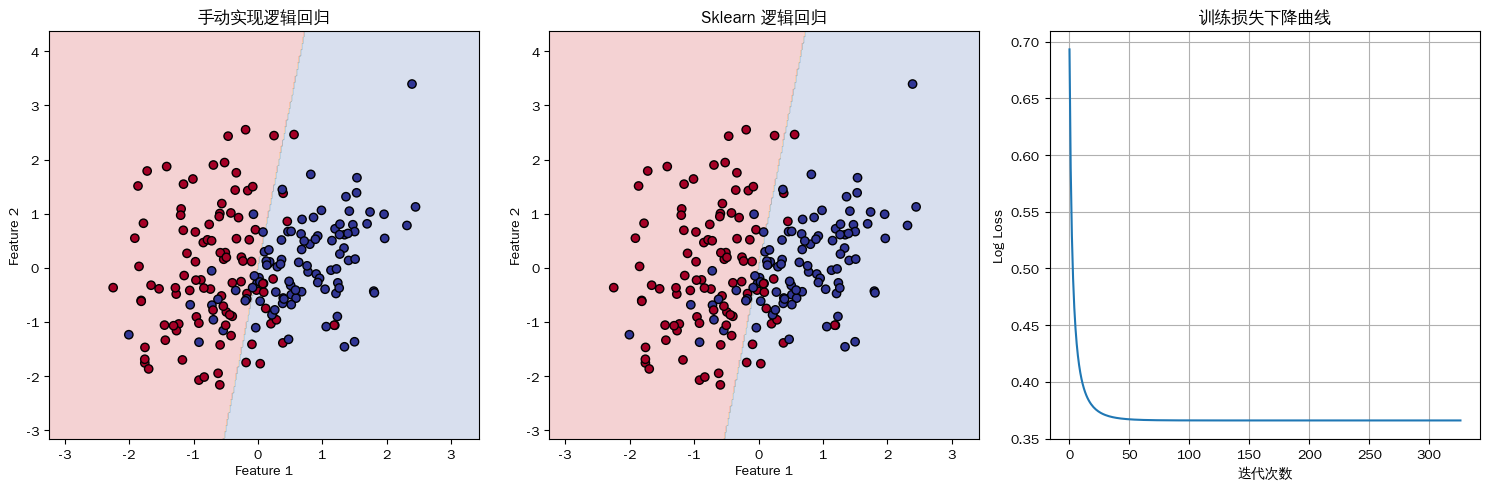

In [9]:
# 6. 可视化：决策边界 + 数据点
def plot_decision_boundary(model, X, y, title=""):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    preds = model.predict(grid).reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.2, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    return scatter

plt.figure(figsize=(15, 5))

# 手动模型
plt.subplot(1, 3, 1)
plot_decision_boundary(manual_model, X_scaled, y, "手动实现逻辑回归")

# Sklearn 模型
plt.subplot(1, 3, 2)
plot_decision_boundary(sklearn_model, X_scaled, y, "Sklearn 逻辑回归")

# 损失函数下降曲线
plt.subplot(1, 3, 3)
plt.plot(manual_model.losses)
plt.title("训练损失下降曲线")
plt.xlabel("迭代次数")
plt.ylabel("Log Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
# 7. 【Bonus】验证预测一致性
y_pred_manual = manual_model.predict(X_scaled)
y_pred_sklearn = sklearn_model.predict(X_scaled)

accuracy_manual = np.mean(y_pred_manual == y)
accuracy_sklearn = np.mean(y_pred_sklearn == y)

print(f"\n🎯 分类准确率:")
print(f"  手动实现: {accuracy_manual:.4f}")
print(f"  Sklearn : {accuracy_sklearn:.4f}")
print(f"  预测一致? {'是' if np.array_equal(y_pred_manual, y_pred_sklearn) else '否'}")


🎯 分类准确率:
  手动实现: 0.8400
  Sklearn : 0.8400
  预测一致? 是
